In [2]:
import os
# base_dir = os.path.abspath('/mnt/ws/home/xyu/ConceptualAlignmentLanguage/tripletNCE')
base_dir = os.path.abspath('/mnt/dv/wid/projects3/Rogers-nsf-ind-diff/sid/Projects/ConceptualAlignmentLanguage/tripletNCE')
save_dir = os.path.join(base_dir,'results')
data_dir = os.path.join(base_dir,'data')

In [3]:
import torch
# torch.manual_seed(0)
import wandb
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torch.utils.data import TensorDataset,Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import Resize

import torchvision
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200


from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

# from neurora.rdm_corr import rdm_correlation_spearman

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Define model

In [5]:
class TripletLabelModel(nn.Module):
    def __init__(self, encoded_space_dim=64, num_classes=10):
        super().__init__()
        ""
        ### Convolutional section
       ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
    
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        ## changed 32*4*4 to 32*2*2
        self.encoder_lin = nn.Sequential(
            nn.Linear(32*2*2, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

        ## triplet projection module
        self.decoder_triplet_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True)
         
        )
        ##labeling module
        self.decoder_labels_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, num_classes),
        )

        ### initialize weights using xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
        
    def forward(self, x, y=None):
        batch_s = x.size(0)
        img_features = self.encoder_cnn(x)
        img_features = self.flatten(img_features)
        
        enc_latent = self.encoder_lin(img_features)

        triplet_latent = self.decoder_triplet_lin(enc_latent)
        label = self.decoder_labels_lin(enc_latent)
        # label = F.softmax(label,dim=1)
        return enc_latent, label

In [6]:
### custom loss computing triplet loss and labeling loss


class CustomLoss(nn.Module):
    def __init__(self, margin=10):
        super(CustomLoss, self).__init__()
        self.margin = margin
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, anchor, positive, negative, label, pred_label):
        cosine_sim = torch.nn.CosineSimilarity(1)
        # distance_positive = torch.tensor(1)-cosine_sim(anchor,positive)
   
        # distance_negative = torch.tensor(1)-cosine_sim(anchor,negative)

        # triplet_loss = torch.maximum(distance_positive - distance_negative + self.margin, torch.tensor(0))
        # triplet_loss = torch.sum(triplet_loss)
        triplet_loss = (nn.TripletMarginWithDistanceLoss( distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y)))
        triplet_loss = triplet_loss(anchor, positive, negative)
        label_loss = self.cross_entropy(pred_label.float().softmax(dim = 1), label.float())
        total_loss = triplet_loss + label_loss
        return triplet_loss, label_loss, total_loss

In [7]:
# t = TripletLabelModel()
# cifar_model_path = '../../data/CIFAR10_NCE_i_1e-05_50.pth'
# t.load_state_dict(torch.load(cifar_model_path))

### Training functions

In [8]:


class TrainModels(nn.Module):
    def __init__(self, latent_dims, num_classes, weights_path=None):
        super(TrainModels, self).__init__()
        self.triplet_lab_model = TripletLabelModel(latent_dims, 10) ### load cifar model
        if weights_path!=None:
            cifar_model_path = '/mnt/dv/wid/projects3/Rogers-nsf-ind-diff/sid/Projects/ConceptualAlignmentLanguage/tripletNCE/data/CIFAR10_NCE_i_1e-05_50.pth'
            self.triplet_lab_model.load_state_dict(torch.load(cifar_model_path))
            self.triplet_lab_model.decoder_labels_lin[4] = nn.Linear(16, num_classes)
        self.custom_loss = CustomLoss()
        self.num_classes = num_classes
    
    def forward(self, anchor_im, positive_im, negative_im):
        anchor_latent, anchor_label = self.triplet_lab_model(anchor_im)
        positive_latent, _ = self.triplet_lab_model(positive_im)
        negative_latent, _ = self.triplet_lab_model(negative_im)

        return anchor_latent, positive_latent, negative_latent, anchor_label

    def test_epoch(self, test_data):
    # Set evaluation mode for encoder and decoder
        self.eval()
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            test_triplet_loss = []
            test_label_loss = []
            test_total_loss = []
            total = 0
            correct = 0
            for anchor_ims, contrast_ims, labels in test_data:
                # Move tensor to the proper device
                anchor_ims = anchor_ims.to(device)
                contrast_ims = contrast_ims.to(device)
                labels = F.one_hot(labels, num_classes=self.num_classes)
                labels = labels.to(device)
                anchor_latent, positive_latent, negative_latent, pred_label = self.forward(anchor_ims, anchor_ims,contrast_ims) 
                # Append the network output and the original image to the lists
                triplet_loss, label_loss, total_loss = self.custom_loss(anchor_latent,
                                                                positive_latent, 
                                                                negative_latent, 
                                                                labels,
                                                                pred_label)
                total += labels.size(0)
                correct += (torch.argmax(pred_label, dim = 1) == torch.argmax(labels, dim = 1)).sum().item()
                test_triplet_loss.append(triplet_loss.item())
                test_label_loss.append(label_loss.item())
                test_total_loss.append(total_loss.item())
        test_triplet_loss = sum(test_triplet_loss)/len(test_triplet_loss)
        test_label_loss = sum(test_label_loss)/len(test_label_loss)
        test_total_loss = sum(test_total_loss)/len(test_total_loss)
        test_accuracy = correct/total
        return test_triplet_loss, test_label_loss, test_total_loss, test_accuracy

    def test_epoch_calculate_representation_separation(self, test_data):
    # Set evaluation mode for encoder and decoder
        self.eval()
        with torch.no_grad(): # No need to track the gradients
            accuracies = []
            for anchor_ims, contrast_ims, labels in test_data:
                # Move tensor to the proper device
                anchor_ims = anchor_ims.to(device)
                contrast_ims = contrast_ims.to(device)
                # labels = F.one_hot(labels, num_classes=self.num_classes)
                # labels = labels.to(device)
                anchor_latent, _, _, _ = self.forward(anchor_ims, anchor_ims,contrast_ims) 
                # use sklearn to predict labels from anchor_latent
                # calculate accuracy
                # x's are anchor_latent and y's are labels
                # append accuracy to list
                # put anchor_latent and labels on cpu and convert to numpy

          
                anchor_latent = anchor_latent.cpu().numpy()
                ### standard scale the data in anchor_latent before fitting to the model
                anchor_latent = StandardScaler().fit_transform(anchor_latent)
                labels = labels.cpu().numpy()
                
                lm = linear_model.LogisticRegression()
                lm.fit(anchor_latent, labels)
                # convert labels to sklearn format
                accuracies.append(lm.score(anchor_latent, labels))
        accuracy = sum(accuracies)/len(accuracies)
        return accuracy

    def train_epoch(self, train_data, optimizer, train_mode):
        self.train()
        train_triplet_loss = []
        train_label_loss = []
        train_total_loss = []
        correct = 0
        total = 0
        for anchor_ims, contrast_ims, labels in train_data:
            
            anchor_ims = anchor_ims.to(device)
            contrast_ims = contrast_ims.to(device)
            labels = F.one_hot(labels, num_classes=self.num_classes)
            labels = labels.to(device)

            optimizer.zero_grad()
            anchor_latent, positive_latent, negative_latent, pred_label = self.forward(anchor_ims, anchor_ims,contrast_ims) 
           
           
           
            triplet_loss, label_loss, total_loss = self.custom_loss(anchor_latent,
                                                                positive_latent, 
                                                                negative_latent, 
                                                                labels,
                                                                pred_label)
            
            
            if train_mode==0:
                triplet_loss.backward()
            elif train_mode==1:
                label_loss.backward()
            elif train_mode==2:
                total_loss.backward()

            optimizer.step()
            train_triplet_loss.append(triplet_loss.item())
            train_label_loss.append(label_loss.item())
            train_total_loss.append(total_loss.item())
            total += labels.size(0)
            correct += (torch.argmax(pred_label, dim = 1) == torch.argmax(labels, dim = 1)).sum().item()
        train_triplet_loss = sum(train_triplet_loss)/len(train_triplet_loss)
        train_label_loss = sum(train_label_loss)/len(train_label_loss)
        train_total_loss = sum(train_total_loss)/len(train_total_loss)
        train_accuracy = correct/total
        return train_triplet_loss, train_label_loss, train_total_loss, train_accuracy

    def training_loop(self, train_data, test_data,train_mode,
                      epochs, optimizer):
        train_losses = []
        val_losses = []
        train_triplet_losses = []
        val_triplet_losses = []
        train_label_losses = []
        val_label_losses = []
        train_accuracies = []
        val_accuracies = []
        latent_separation_accuracy = 0
        for epoch in tqdm(range(epochs)):
          train_triplet_loss, train_label_loss, train_total_loss, train_accuracy =self.train_epoch(train_data, optimizer, 
                                             train_mode)
          test_triplet_loss, test_label_loss, test_total_loss, test_accuracy = self.test_epoch(test_data)
          separation_accuracy = self.test_epoch_calculate_representation_separation(test_data)
          train_losses.append(train_total_loss)
          val_losses.append(test_total_loss)
          train_triplet_losses.append(train_triplet_loss)
          val_triplet_losses.append(test_triplet_loss)
          train_label_losses.append(train_label_loss)
          val_label_losses.append(test_label_loss)
          train_accuracies.append(train_accuracy)
          val_accuracies.append(test_accuracy)
          wandb.log({"train triplet loss": train_triplet_loss, 
            "train label loss":train_label_loss, 
            "validation triplet loss":test_triplet_loss, 
            "validation label loss":test_label_loss, 
            "total train loss":train_total_loss, 
            "total validation loss":test_total_loss, 
            "train label accuracy":train_accuracy, 
            "validation label accuracy":test_accuracy,
            'latent separation accuracy':separation_accuracy})
        return train_triplet_losses, train_label_losses, val_triplet_losses, val_label_losses ,train_losses, val_losses, train_accuracies, val_accuracies


In [9]:
set_A_ims = np.load(os.path.join(data_dir, 'set_A.npy'))
set_B_ims = np.load(os.path.join(data_dir, 'set_B.npy'))
set_C_ims = np.load(os.path.join(data_dir, 'set_C.npy'))
set_A_labs = np.load(os.path.join(data_dir, 'set_A_labs.npy'))
set_B_labs = np.load(os.path.join(data_dir, 'set_B_labs.npy'))
set_C_labs = np.load(os.path.join(data_dir, 'set_C_labs.npy'))


In [10]:

set_A_sub_ims =[]
set_B_sub_ims =[]

set_C_sub_ims =[]

set_A_sub_labs =[]
set_B_sub_labs =[]
set_C_sub_labs =[]


for i in range (4):
    sub_main = set_A_ims[i*600:(i*600)+600]
    labels_main = set_A_labs[i*600:(i*600)+600]
    np.random.seed(711)
    np.random.shuffle(sub_main)
    np.random.seed(711)
    np.random.shuffle(labels_main)

    set_A_sub_ims.append(sub_main[:30])
    set_B_sub_ims.append(sub_main[:15])
    set_B_sub_ims.append(sub_main[30:45])
    set_C_sub_ims.append(sub_main[35:65])

    set_A_sub_labs.append(labels_main[:30])
    set_B_sub_labs.append(labels_main[:15])
    set_B_sub_labs.append(labels_main[30:45])
    set_C_sub_labs.append(labels_main[35:65])


    




##flatten set_A_sub_ims into an array of shape 120,64,64,3
set_A_sub_ims = np.concatenate(set_A_sub_ims)
set_B_sub_ims = np.concatenate(set_B_sub_ims)
set_C_sub_ims = np.concatenate(set_C_sub_ims)

set_A_sub_labs = np.concatenate(set_A_sub_labs)
set_B_sub_labs = np.concatenate(set_B_sub_labs)
set_C_sub_labs = np.concatenate(set_C_sub_labs)


A-B: 50% \
A-C: 0% \
B-C: 33.33%

In [11]:

###initialize weights and bias tracking
def wandb_init(epochs, lr, train_mode, batch_size, model_number,data_set):
    wandb.init(project="ConceptualAlignment", settings=wandb.Settings(start_method="thread"))
    wandb.config = {
      "learning_rate": lr,
      "epochs": epochs,
      "batch_size": batch_size, 
      # "label_ratio":label_ratio, 
      "model_number": model_number,
      "dataset": data_set,
      "train_mode":train_mode,
    }
    train_mode_dict = {0:'triplet', 1:'label', 2:'label_and_triplet'}
    wandb.run.name = f'{data_set}_{train_mode_dict[train_mode]}_{model_number}'
    wandb.run.save()
     

In [16]:

def main_code(save_dir, num_models, epochs, num_classes, batch_size,
             lr, latent_dims):
  if os.path.isdir(save_dir):
    pass
  else:
    os.mkdir(save_dir)
  random.seed(42)
  np.random.seed(42)
  torch.manual_seed(42)
  
  # test_intervals = [(540, 600), (1140, 1200), (1740, 1800), (2340, 2400)]
  test_intervals = [(25, 30), (55, 60), (85, 90), (115, 120)]
  # initialize an empty list to hold the indices
  val_indices = []

  # loop through the intervals and append the indices to the list
  for start, stop in test_intervals:
      val_indices.extend(list(range(start, stop)))

  # train_indices = (np.setdiff1d(np.arange(2400),np.array(val_indices)))
  train_indices = (np.setdiff1d(np.arange(120),np.array(val_indices)))

  # np.random.seed(56)
  # contrast_indices  = np.concatenate((np.random.choice(np.arange(start=600, stop=2400), 600, replace=False),
  #               np.random.choice(np.concatenate((np.arange(start=0, stop=600), np.arange(start=1200, stop=2400))), 600, replace=False),
  #               np.random.choice(np.concatenate((np.arange(start=0, stop=1200), np.arange(start=1800, stop=2400))), 600, replace=False),
  #               np.random.choice(np.arange(start=1800, stop=2400), 600, replace=False)))
  contrast_indices  = np.concatenate((np.random.choice(np.arange(start=30, stop=120), 30, replace=False),
                np.random.choice(np.concatenate((np.arange(start=0, stop=30), np.arange(start=60, stop=120))), 30, replace=False),
                np.random.choice(np.concatenate((np.arange(start=0, stop=60), np.arange(start=90, stop=120))), 30, replace=False),
                np.random.choice(np.arange(start=0, stop=90), 30, replace=False)))

  # for data_set in ['set_A','set_A2','set_B','set_C']:
  for data_set in ['set_A']:
    for train_mode in tqdm(range(2, 3)):
     # torch.manual_seed(0)
      for model in range(num_models):
        wandb_init(epochs, lr, train_mode, batch_size, model,data_set)
        weights_path = f'../../data/cifar_models/m{model}.pth'

        if data_set=='set_A':
          train_data = TensorDataset(Resize(32)(torch.tensor(set_A_sub_ims.transpose(0,3,1,2)/255).float()), Resize(32)(torch.tensor(set_A_sub_ims[contrast_indices].transpose(0,3,1,2)/255).float()),\
                                     torch.tensor(set_A_sub_labs).to(torch.int64))
          # train_data = TensorDataset(Resize(32)(torch.tensor(set_A_ims.transpose(0,3,1,2)/255).float()), Resize(32)(torch.tensor(set_A_ims.transpose(0,3,1,2)/255).float()),\
          #                            torch.tensor(set_A_labs).to(torch.int64))
        else:
          exit()
        train_size = int(0.7 * len(train_data))
        val_size = len(train_data) - train_size
        
        train_data, val_data = random_split(train_data, [train_size, val_size], generator=torch.Generator().manual_seed(42))
       

        train_data = torch.utils.data.DataLoader(train_data, 
                                                batch_size=batch_size,
                                              shuffle=True)
        val_data = torch.utils.data.DataLoader(val_data, 
                                                batch_size=batch_size,
                                              shuffle=False)
        
        
        # assert(len(test_data.dataset) == test_size)
        assert(len(train_data.dataset) == train_size)
        assert(len(val_data.dataset) == val_size)

        train_obj = TrainModels(latent_dims, num_classes, weights_path).to(device) # GPU
        optimizer = torch.optim.Adam(train_obj.parameters(), lr=lr, weight_decay=1e-05)
        train_triplet_losses, train_label_losses, \
          val_triplet_losses, val_label_losses, \
            train_losses, val_losses, train_accuracies, val_accuracies= train_obj.training_loop(train_data = train_data,
                                                            test_data = val_data,
                                                            epochs = epochs,
                                                            optimizer = optimizer, 
                                                            train_mode = train_mode)


        

        print('validation triplet loss:',val_triplet_losses[-1],'validation total loss:',val_losses[-1],'validation accuracy:',val_accuracies[-1])
        # wandb.log({"train_img_loss": train_img_loss, 
        #           "train_label_loss":train_label_loss, 
        #           "val_img_loss":val_img_loss, 
        #           "val_label_loss":val_label_loss, 
        #           "train_losses":train_losses, 
        #           "val_losses":val_losses, 
        #           "train_accuracy":train_accuracy, 
        #           "val_accuracy":val_accuracy})
        train_mode_dict = {0:'triplet', 1:'label',2:'label_and_triplet' }
        torch.save(train_obj.triplet_lab_model.state_dict(), os.path.join(save_dir,'sid_checkpoints', 'before_self_talk_all_set_A',f'{model}_{data_set}_{train_mode_dict[train_mode]}_{round(val_accuracies[-1], 3)}_sid_ce.pth'))
  return val_data
        



In [17]:
wandb.finish()

num_classes = 4 # Number of unique class labels in the dataset
latent_dims = 64
epochs = 1
lr = 0.005
num_models = 1
batch_size = 256
save_dir = save_dir
# to check if dataset is the same
val_datas = []
for epochs in [1, 2, 3, 4, 5, 10, 20, 50]:
    val_datas.extend([main_code(save_dir, num_models, epochs, num_classes, batch_size,
                lr, latent_dims)])
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/1 [00:00<?, ?it/s]

/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1/1 [00:09<00:00,  9.46s/it]


validation triplet loss: 0.6189886927604675 validation total loss: 2.012028932571411 validation accuracy: 0.08333333333333333


  0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


latent separation accuracy,▁
total train loss,▁
total validation loss,▁
train label accuracy,▁
train label loss,▁
train triplet loss,▁
validation label accuracy,▁
validation label loss,▁
validation triplet loss,▁
latent separation accuracy,1.0
total train loss,1.66787


/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1/1 [00:12<00:00, 12.93s/it]/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/wandb/sdk/wandb_run.py:2163: UserWarning: Run (2dvsjb7y) is finished. The call to `_consol

validation triplet loss: 0.6196682453155518 validation total loss: 2.009838104248047 validation accuracy: 0.16666666666666666


  0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


latent separation accuracy,▁▁
total train loss,█▁
total validation loss,█▁
train label accuracy,▁█
train label loss,█▁
train triplet loss,█▁
validation label accuracy,▁█
validation label loss,█▁
validation triplet loss,▁█
latent separation accuracy,1.0
total train loss,1.41522


/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1/1 [00:12<00:00, 12.78s/it]/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/wandb/sdk/wandb_run.py:2163: UserWarning: Run (j250abx8) is finished. The call to `_consol

validation triplet loss: 0.606200098991394 validation total loss: 1.9964025020599365 validation accuracy: 0.2777777777777778


  0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


latent separation accuracy,▁▁▁
total train loss,█▂▁
total validation loss,█▇▁
train label accuracy,▁▂█
train label loss,█▅▁
train triplet loss,█▁▁
validation label accuracy,▁▄█
validation label loss,█▁▁
validation triplet loss,██▁
latent separation accuracy,1.0
total train loss,1.38504


/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1/1 [00:13<00:00, 13.46s/it]/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/wandb/sdk/wandb_run.py:2163: UserWarning: Run (6facy121) is finished. The call to `_consol

validation triplet loss: 0.622480571269989 validation total loss: 2.0152742862701416 validation accuracy: 0.2222222222222222


  0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


latent separation accuracy,▁▁▁▁
total train loss,█▂▂▁
total validation loss,▇▆▁█
train label accuracy,▁▂▆█
train label loss,█▆▄▁
train triplet loss,█▂▁▁
validation label accuracy,▁▄█▅
validation label loss,█▁▁▇
validation triplet loss,▆▇▁█
latent separation accuracy,1.0
total train loss,1.34712


/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1/1 [00:26<00:00, 26.79s/it]/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/wandb/sdk/wandb_run.py:2163: UserWarning: Run (clg05gqh) is finished. The call to `_consol

validation triplet loss: 0.6387975811958313 validation total loss: 2.041337251663208 validation accuracy: 0.2222222222222222


  0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


latent separation accuracy,▁▁▁▁▁
total train loss,█▃▂▂▁
total validation loss,▃▃▁▄█
train label accuracy,▁▂▆██
train label loss,█▇▆▄▁
train triplet loss,█▂▁▁▁
validation label accuracy,▁▄█▅▅
validation label loss,▃▁▁▂█
validation triplet loss,▄▄▁▄█
latent separation accuracy,1.0
total train loss,1.31469


/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1/1 [00:13<00:00, 13.44s/it]/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/wandb/sdk/wandb_run.py:2163: UserWarning: Run (jphb22bl) is finished. The call to `_consol

validation triplet loss: 0.7250034809112549 validation total loss: 2.2734451293945312 validation accuracy: 0.16666666666666666


  0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


latent separation accuracy,▁▁▁▁▁▁▁▁▁▁
total train loss,█▅▅▄▄▃▃▂▁▁
total validation loss,▁▁▁▁▂▄▅▆██
train label accuracy,▁▂▅▆▇▇▇▇██
train label loss,██▇▇▆▅▄▃▂▁
train triplet loss,█▂▂▁▁▁▁▁▁▁
validation label accuracy,▁▄█▆▆▆▄▄▄▄
validation label loss,▁▁▁▁▂▂▄▆██
validation triplet loss,▂▂▁▂▃▅▆▇██
latent separation accuracy,1.0
total train loss,1.06491


/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1/1 [00:13<00:00, 13.71s/it]/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/wandb/sdk/wandb_run.py:2163: UserWarning: Run (6i3p0rd0) is finished. The call to `_consol

validation triplet loss: 0.24147076904773712 validation total loss: 1.4086817502975464 validation accuracy: 0.5555555555555556


  0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


latent separation accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total train loss,█▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁
total validation loss,▆▆▆▆▆▇▇▇███▇▇▆▅▄▃▃▂▁
train label accuracy,▁▁▃▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
train label loss,███▇▇▆▆▅▄▄▄▃▃▃▃▂▂▂▁▁
train triplet loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation label accuracy,▁▂▄▃▃▃▂▂▂▂▂▂▃▄▄▅▆▆▇█
validation label loss,▅▅▅▅▅▆▆▇████▇▆▅▄▃▃▂▁
validation triplet loss,▆▆▆▆▇▇▇████▇▆▅▅▄▃▂▁▁
latent separation accuracy,1.0
total train loss,0.83984


/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1/1 [00:14<00:00, 14.60s/it]/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/wandb/sdk/wandb_run.py:2163: UserWarning: Run (7d2bbws1) is finished. The call to `_consol

validation triplet loss: 0.15564759075641632 validation total loss: 1.1976622343063354 validation accuracy: 0.6944444444444444


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


latent separation accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total train loss,█▆▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total validation loss,▆▆▆▆▇▇████▇▆▅▄▄▃▂▁▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train label accuracy,▁▁▃▄▄▅▅▅▅▅▅▆▆▆▇▇████████████████████████
train label loss,███▇▇▆▅▅▄▄▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train triplet loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation label accuracy,▁▂▃▂▂▂▂▂▂▂▂▃▅▅▅▅██▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
validation label loss,▆▆▆▆▆▇▇████▇▅▄▄▄▂▁▁▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
validation triplet loss,▇▇▇▇▇█████▇▆▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
latent separation accuracy,1.0
total train loss,0.74373


In [ ]:
# want the final layer logits , compute error based on the maximum logits ground truth 

# sid changes

In [21]:
import pickle
import pandas as pd

In [21]:
batch_size = 256
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
contrast_indices  = np.concatenate((np.random.choice(np.arange(start=30, stop=120), 30, replace=False),
                np.random.choice(np.concatenate((np.arange(start=0, stop=30), np.arange(start=60, stop=120))), 30, replace=False),
                np.random.choice(np.concatenate((np.arange(start=0, stop=60), np.arange(start=90, stop=120))), 30, replace=False),
                np.random.choice(np.arange(start=0, stop=90), 30, replace=False)))
# train_data = TensorDataset(Resize(32)(torch.tensor(set_A_sub_ims.transpose(0,3,1,2)/255).float()), Resize(32)(torch.tensor(set_A_sub_ims[contrast_indices].transpose(0,3,1,2)/255).float()),\
#                                      torch.tensor(set_A_sub_labs).to(torch.int64))
train_data = TensorDataset(Resize(32)(torch.tensor(set_C_ims.transpose(0,3,1,2)/255).float()), Resize(32)(torch.tensor(set_C_ims.transpose(0,3,1,2)/255).float()),\
                                     torch.tensor(set_C_labs).to(torch.int64))
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size
# test_size = len(train_data) - train_size - val_size

train_data, val_data = random_split(train_data, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_data = torch.utils.data.DataLoader(train_data,
                                                batch_size=batch_size,
                                              shuffle=True) 
val_data = torch.utils.data.DataLoader(val_data,
                                                batch_size=batch_size,
                                                shuffle=False)
# test_data = torch.utils.data.DataLoader(test_data,
#                                                 batch_size=batch_size,
#                                               shuffle=False)                       

In [22]:
train_size, val_size

(1680, 720)

In [23]:
# class MaxLogitsLoss(torch.nn.Module):
#     def __init__(self):
#         super(MaxLogitsLoss, self).__init__()

#     def forward(self, logits, targets):
#         max_logits = torch.sum(logits * targets, dim=1)
#         loss = -max_logits.mean()
#         return loss
latent_dims = 64

# model_path = {38: "./results/sid_checkpoints/0_set_A_label_and_triplet_0.389_sid_ce.pth",
#               44: "./results/sid_checkpoints/0_set_A_label_and_triplet_0.444_sid_ce.pth",
#               50: "./results/sid_checkpoints/0_set_A_label_and_triplet_0.5_sid_ce.pth",
#               55: "./results/sid_checkpoints/0_set_A_label_and_triplet_0.556_sid_ce.pth",
#               66: "./results/sid_checkpoints/0_set_A_label_and_triplet_0.667_sid_ce.pth",
#               72: "./results/sid_checkpoints/0_set_A_label_and_triplet_0.722_sid_ce.pth",
#               77: "./results/sid_checkpoints/0_set_A_label_and_triplet_0.778_sid_ce.pth",
#               83: "./results/sid_checkpoints/0_set_A_label_and_triplet_0.833_sid_ce.pth"}

model_paths = {}
for fname in os.listdir(os.path.join(save_dir,'sid_checkpoints', 'before_self_talk_all_set_A')):
    if fname.endswith('.pth'):
        model_paths[str(fname.split('_')[-3])] = fname
model_paths

for choose in model_paths.keys():
    print('===================================================')
    triplet_lab_model = TripletLabelModel(latent_dims, 4)
    triplet_lab_model.load_state_dict(torch.load(os.path.join(save_dir,'sid_checkpoints', 'before_self_talk_all_set_A', model_paths[str(choose)])))
    triplet_lab_model = triplet_lab_model.to(device)
    # criterion = MaxLogitsLoss()
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(triplet_lab_model.parameters(), lr=0.001)
    num_epochs = 200

    for epoch in range(num_epochs):
        correct = 0
        total = 0
        for anchor_ims, contrast_ims, labels in train_data:
            anchor_ims = anchor_ims.to(device)
            contrast_ims = contrast_ims.to(device)
            # labels = F.one_hot(labels, num_classes=4)
            # import ipdb;ipdb.set_trace()
            labels = labels.to(device)
            
            optimizer.zero_grad()
            _, label_logits = triplet_lab_model(anchor_ims)
            predicted_labels = torch.argmax(label_logits, dim=1)
            # import ipdb; ipdb.set_trace()
            loss = criterion(label_logits, predicted_labels)
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(label_logits.data, 1)
            # _, labels_max = torch.max(labels.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
        if epoch%20==0:
            print(f"Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy}%")
        
        # print(f"Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy}%")

    print(f"Pretrained Model: {choose}, Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy}%")
    save_path = os.path.join(save_dir,'sid_checkpoints', 'after_self_talk_all_set_A',  f'0_set_A_maxlogits_acc_{choose}.pth')
    torch.save(triplet_lab_model.state_dict(), save_path)
    print('===================================================')



Epoch 0, Loss: 0.6636428833007812, Accuracy: 37.916666666666664%
Epoch 20, Loss: 0.00100385257974267, Accuracy: 27.55952380952381%
Epoch 40, Loss: 6.923260662006214e-05, Accuracy: 27.738095238095237%
Epoch 60, Loss: 4.833959974348545e-05, Accuracy: 27.738095238095237%
Epoch 80, Loss: 3.9166287024272606e-05, Accuracy: 27.738095238095237%
Epoch 100, Loss: 1.7539585314807482e-05, Accuracy: 27.738095238095237%
Epoch 120, Loss: 1.245966359419981e-05, Accuracy: 27.738095238095237%
Epoch 140, Loss: 2.1402658603619784e-05, Accuracy: 27.738095238095237%
Epoch 160, Loss: 5.995202172925929e-06, Accuracy: 27.738095238095237%
Epoch 180, Loss: 6.452137768064858e-06, Accuracy: 27.738095238095237%
Pretrained Model: 0.278, Epoch 199, Loss: 2.7835872970172204e-05, Accuracy: 27.738095238095237%
Epoch 0, Loss: 0.1951259970664978, Accuracy: 52.916666666666664%
Epoch 20, Loss: 0.009456049650907516, Accuracy: 33.51190476190476%
Epoch 40, Loss: 0.007158354856073856, Accuracy: 23.333333333333332%
Epoch 60, Los

## before after self talk accuracies and saving latents

In [24]:
import pandas as pd
latent_dims = 64

# model_path = {38: "./results/sid_checkpoints/0_set_A_label_and_triplet_0.389_sid_ce.pth",
#               44: "./results/sid_checkpoints/0_set_A_label_and_triplet_0.444_sid_ce.pth",
#               50: "./results/sid_checkpoints/0_set_A_label_and_triplet_0.5_sid_ce.pth",
#               55: "./results/sid_checkpoints/0_set_A_label_and_triplet_0.556_sid_ce.pth",
#               66: "./results/sid_checkpoints/0_set_A_label_and_triplet_0.667_sid_ce.pth",
#               72: "./results/sid_checkpoints/0_set_A_label_and_triplet_0.722_sid_ce.pth",
#               77: "./results/sid_checkpoints/0_set_A_label_and_triplet_0.778_sid_ce.pth",
#               83: "./results/sid_checkpoints/0_set_A_label_and_triplet_0.833_sid_ce.pth",}

# chooses = model_path.keys()
# model_paths = {}
model_fnames = []
for fname in os.listdir(os.path.join(save_dir,'sid_checkpoints', 'before_self_talk_all_set_A')):
    if fname.endswith('.pth'):
        model_fnames.append(fname.split('_')[-3])
df = pd.DataFrame(columns=['model_name', 'type' 'accuracy'])
for choose in model_fnames:
    for model_type in ['before_self_talk', 'after_self_talk']:
        triplet_lab_model = TripletLabelModel(latent_dims, 4)
        if model_type == 'before_self_talk':
            triplet_lab_model.load_state_dict(torch.load(os.path.join(save_dir,'sid_checkpoints', 'before_self_talk_all_set_A', f'0_set_A_label_and_triplet_{choose}_sid_ce.pth')))
        else:
            triplet_lab_model.load_state_dict(torch.load(os.path.join(save_dir,'sid_checkpoints', 'after_self_talk_all_set_A', f'0_set_A_maxlogits_acc_{choose}.pth')))
        triplet_lab_model = triplet_lab_model.to(device)
        total = 0
        correct = 0
        latent_temp = np.zeros((val_size, latent_dims))
        labels_temp = []
        for anchor_ims, contrast_ims, labels in val_data:
            anchor_ims = anchor_ims.to(device)
            contrast_ims = contrast_ims.to(device)
            # labels = F.one_hot(labels, num_classes=4)
            # import ipdb; ipdb.set_trace()
            labels = labels.to(device)
            labels_temp.extend(labels.cpu().detach())
            # optimizer.zero_grad()
            latents, label_logits = triplet_lab_model(anchor_ims)
            latent_temp[total:total+labels.size(0)] = latents.cpu().detach().numpy()
            # import ipdb; ipdb.set_trace()
            predicted_labels = torch.argmax(label_logits, dim=1)
            
            # Calculate accuracy
            _, predicted = torch.max(label_logits.data, 1)
            # _, labels_max = torch.max(labels.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
        # save latents and labels as a pandas dataframe csv
        # import ipdb; ipdb.set_trace()
        if model_type == 'before_self_talk':
            pd.DataFrame(latent_temp, index=labels_temp).to_csv(os.path.join(save_dir,'latents_self_talk', 'before', f'{choose}.csv'))
        else:
            pd.DataFrame(latent_temp, index=labels_temp).to_csv(os.path.join(save_dir,'latents_self_talk', 'after', f'{choose}.csv'))
        
        df = pd.concat([df, pd.DataFrame([[choose, model_type, accuracy]], columns=['model_name', 'type', 'accuracy'])], ignore_index=True)

        
        # print(f"Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy}%")
        




In [25]:
df

,model_name,typeaccuracy,type,accuracy
0,0.278,NaN,before_self_talk,44.444444
1,0.278,NaN,after_self_talk,26.805556
2,0.167,NaN,before_self_talk,56.944444
3,0.167,NaN,after_self_talk,32.916667
4,0.694,NaN,before_self_talk,74.444444
5,0.694,NaN,after_self_talk,28.194444
6,0.083,NaN,before_self_talk,30.972222
7,0.083,NaN,after_self_talk,25.555556
8,0.556,NaN,before_self_talk,72.777778
9,0.556,NaN,after_self_talk,25.416667


In [31]:
latent_separation_df = pd.DataFrame(columns=['model_name', 'type', 'accuracy'])

# use latents to predict labels by training a logistic regression model
# calculate accuracy of the model

fnames = os.listdir(os.path.join(save_dir,'latents_self_talk', 'before'))

for type in ['before', 'after']:
    for fname in fnames:
        # print(fname)
        latent_df = pd.read_csv(os.path.join(save_dir,'latents_self_talk', type, fname), index_col=0)
        latent_df = latent_df.sample(frac=1)
        latent_df = latent_df.reset_index(drop=True)
        labels = latent_df.index
        latent_df = latent_df.to_numpy()
        lm = linear_model.LogisticRegression()
        lm.fit(latent_df, labels)
        latent_separation_df = pd.concat([latent_separation_df, pd.DataFrame([[fname.split('.csv')[0], type, lm.score(latent_df, labels)]], columns=['model_name', 'type', 'accuracy'])], ignore_index=True)

/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/mnt/dv/wid/projects3/Rogers-muri-human-ai/sid/tmp/envs/alignment2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

In [32]:
latent_separation_df.pivot_table(index='model_name', columns='type', values='accuracy')

type,after,before
model_name,,
0.083,0.881944,1.000000
0.167,0.861111,0.997222
0.222,0.983333,1.000000
0.278,0.912500,1.000000
0.556,0.693056,1.000000
0.694,0.598611,0.998611


In [33]:
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform

categoricality_df = pd.DataFrame(columns=['model_name', 'type', 'categoricality'])

# use latents to predict labels by training a logistic regression model
# calculate accuracy of the model

fnames = os.listdir(os.path.join(save_dir,'latents_self_talk', 'before'))

for type in ['before', 'after']:
    for fname in fnames:
        latent_df = pd.read_csv(os.path.join(save_dir,'latents_self_talk', type, fname), index_col=0)
        latent_df.sort_index()
        latent_df = latent_df.sample(frac=1)
        latent_df = latent_df.reset_index(drop=True)
        labels = latent_df.index
        latent_df = latent_df.to_numpy()
        dist = pdist(latent_df)
        blocksize = 120
        block_diag = np.zeros((720,720))
        for l in range(4):
            block_diag[l*blocksize:(l+1)*blocksize,l*blocksize:(l+1)*blocksize] = 1

        ### mask distA with block_diag
        within_dist = squareform(dist)*block_diag
        between_dist = squareform(dist)*(1-block_diag)

        categoricality = np.log(np.mean(between_dist)/np.mean(within_dist))
        categoricality_df = pd.concat([categoricality_df, pd.DataFrame([[fname.split('.csv')[0], type, categoricality]], columns=['model_name', 'type', 'categoricality'])], ignore_index=True)

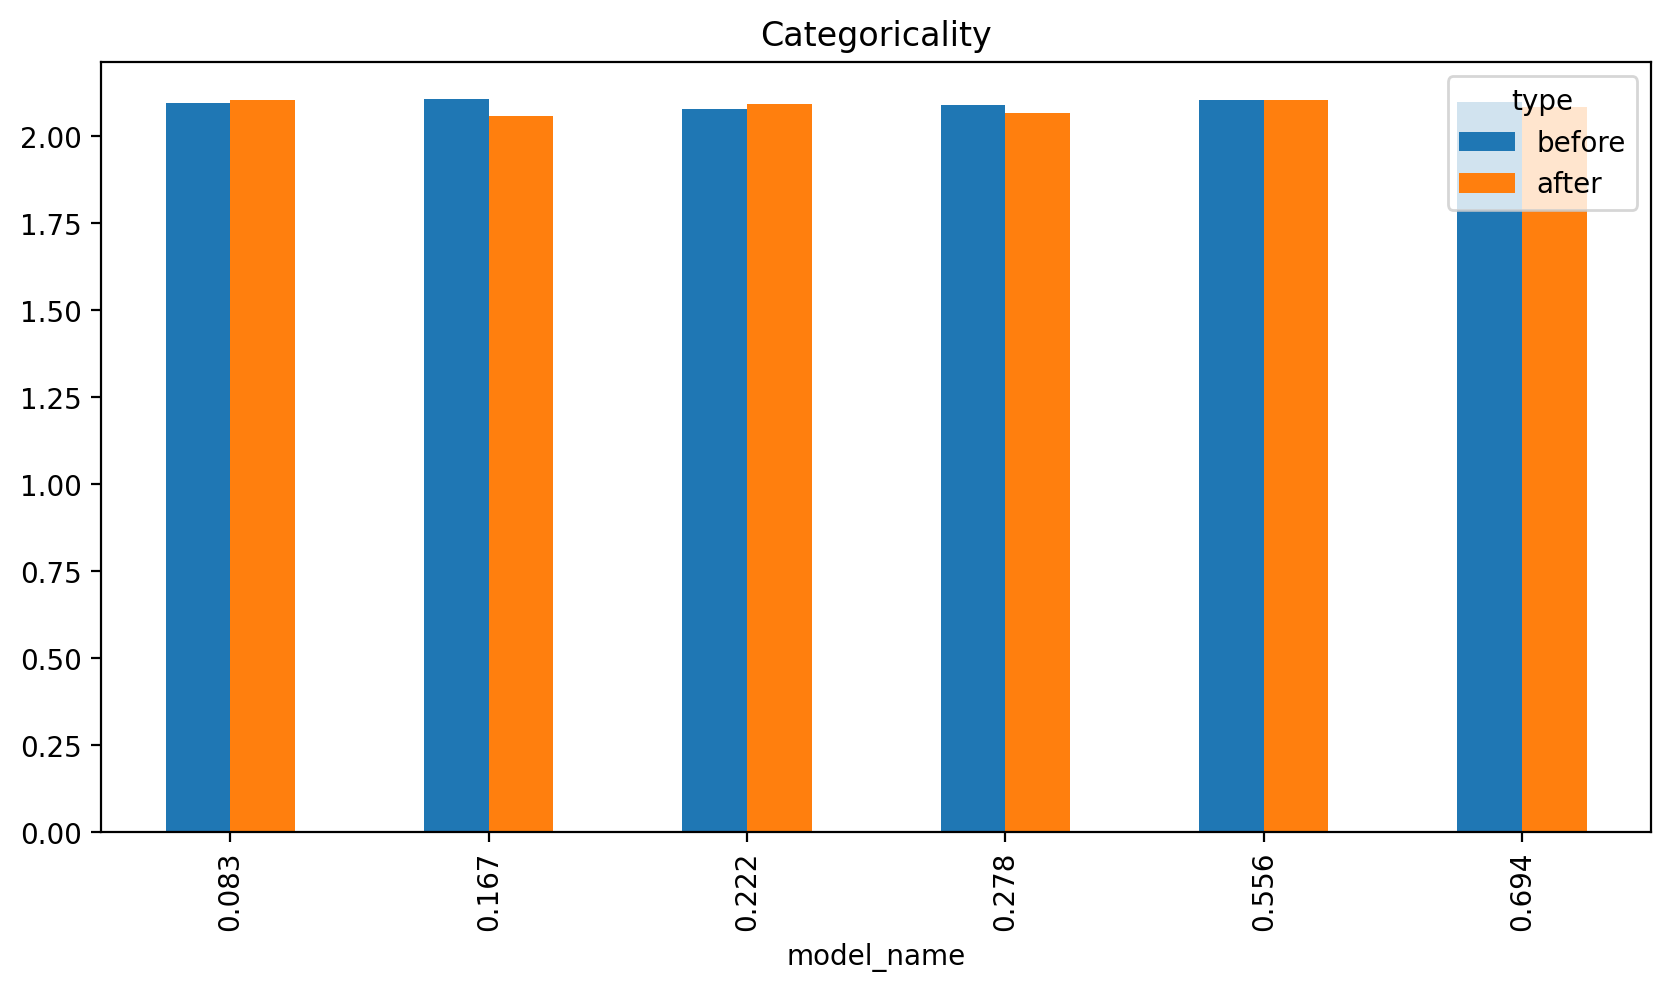

In [34]:
categoricality_df.pivot_table(index='model_name', columns='type', values='categoricality')[['before', 'after']].plot(kind='bar', figsize=(10, 5), title='Categoricality')

## 